In [1]:
#Include important files
include("TestBestPlannerHeader.jl")
include("BestLocalPlannerGuts.jl")


debugPlotDash (generic function with 1 method)

In [7]:
#Construct the all the containers
tuningI = TuningParams([0;1;0;1;0],    # q_coeff::Vector{Int64}
                       [500.0;5000.0], # softConstrWeights::Vector{Float64}
                        0.2,           # numericVelWeight::Float64       
                        0.01,          # obstacleWeight::Float64    
                        0.1,           # derivativeWeight::Float64     
                        0.02,          # precision::Float64              
                        1000,            # iterations::Int64      
                        0.01,          # timeStep::Float64     
                        2.0,           # timeStart::Float64    
                        0.7,           # aggressParam:Float64        
                        0.1,           # timeIncrease::Float64            
                        2.0,           # max_vel::Float64           
                        0.65,          # max_accel::Float64        
                        10.0,          # max_jerk::Float64             
                        10,            # numberOfRandomRestarts::Int64   
                        10,            # timeWeight::Float64    
                        100,           # timeRes::Int64   
                        0.01,          # precisionVel::Float64            
                        0.95,          # percentAcc::Float64               
                        1.0);          # accelWeight::Float64           
problem = PathProblem( [1.0 0.0 0.0;        # x
                        1.0 0.0 0.0;        # y
                        1.0 0.0 0.0],       # z  #start_config::Array{Float64,2}   
                       [5.0;                # x
                        5.0;                # y
                        7.0]'',             # z #end_config::Array{Float64,2}      
                       [true],              # soft_constr::Vector{Bool}     
                        true,               # DijkstraNotFMT::Bool          
                        zeros(0,2),         # PconstrFixed::Array{Float64,2}  
    #TODO: actually create a constructor function to construct the constr* and time index vectors
                        zeros(0,2),         # PconstrFree::Array{Float64,2}       
                        [0;0;0;1;1;1],      # PtimeIndex::Vector{Int64}       
                        [0;1;2;0;1;2],      # PconstraintOrders::Vector{Int64}
                        zeros(0,2),         # PconstraintSoft::Array{Float64,2}    
                        false,              # isDim3::Bool                  
                        1,                  # dof::{Int64}                   
                        zeros(0,0,1),       # costmap::Array{Int8,3}         
                        7.0,               # grid_extent::Float64  
                        0.1,                # grid_resolution::Float64
                        0,                  # Pgrid_elementNum::Int64 
                        0)                  # Pdegree::Int64 
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            false,   #    PoutOfBounds::Bool                 
                            false,   #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64         

PolyPathSolver([0.0],[0.0],[0.0],false,false,10,100)

In [ ]:
#Do the lotus test
lotusTest(  5.0,       # initial_distance::Float64, 
            tuningI,   # tuning::TuningParams, 
            2,         # number2Rotate::Int64,
            2.0,       # distanceChange::Float64, 
            1,         # figureNum::Int64)
            problem)   # pathProb::PathProblem

In [ ]:
#Easy Bump Test
easyAvoidBumpTest(  tuningI,# bumpTuning::TuningParams, 
                    problem,# pathProblem::PathProblem, 
                    5000,   # bumpSize::Int64)
                    2,      # figNum::Int64 = 1
                    7.0)    # bumpYLoc::Float64 default is 5.0

In [ ]:
#Doorway Test
#TODO: make params more understandable/consistent with user expectations
#TODO: Add input validation to this test
doorwayTest(tuningI,#wallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            30,     #wallSize::Int64, 
            3,      #figNum::Int64, 
            7.0,    #doorYLoc::Float64, 
            10.0,   #doorWidth::Float64)
            true,   #wallBehindDoor::Bool = false, 
            1.5)    #wallDistance::Float64 = 2.0

In [ ]:
#Hallway Test
#TODO: Add input validation to this test
hallwayTest(tuningI,#hallTuning::TuningParams, 
            problem,#pathProblem::PathProblem, 
            35,     #wallSize::Int64, 
            4)      #figNum::Int64)

In [ ]:
#Random Tuning/Problem Variation Test
#Descritption - the tuning parameters will be varied through a range of values for a constant path problem. Only
# one thing changes
#Requires heavy user input
#This is the Skeleton of the process and a specific variable should be used
#Set bottom value
#Set top value
#Create range between those values
#Loop through the range 
#Set the current value to its appropriate spot in the object
#Run the planner
#Plot
#End Loop

In [ ]:
#Random Ros Bag Test
#Description - read in a ros bag's costmap and path for that costmap
#Inputs
# rosbag
#Expected Outcomes - a plot 

#Pseudo code since I do not know how to do this in Julia yet
#Read in rosbag
#Record a coinciding costmap and global path
#Translate to odom frame
#Pick local goals
#Start timer
#Run path planner
#If unsuccessful choose a different goal until out of goals or successful
#End timer
#Print time
#Plot planned path over the costmap

cost before: 99.88305012566164


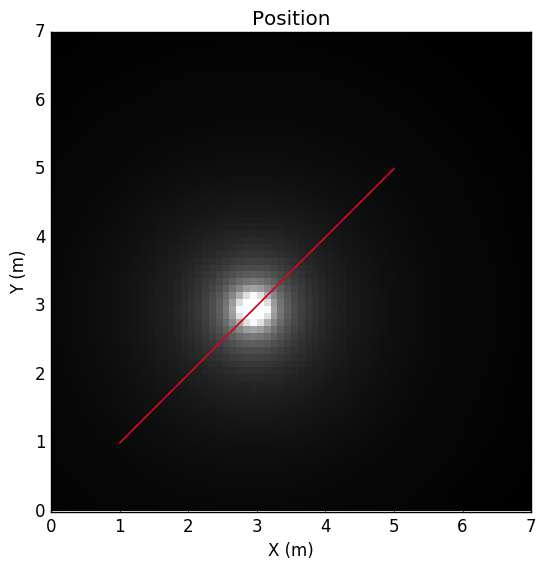

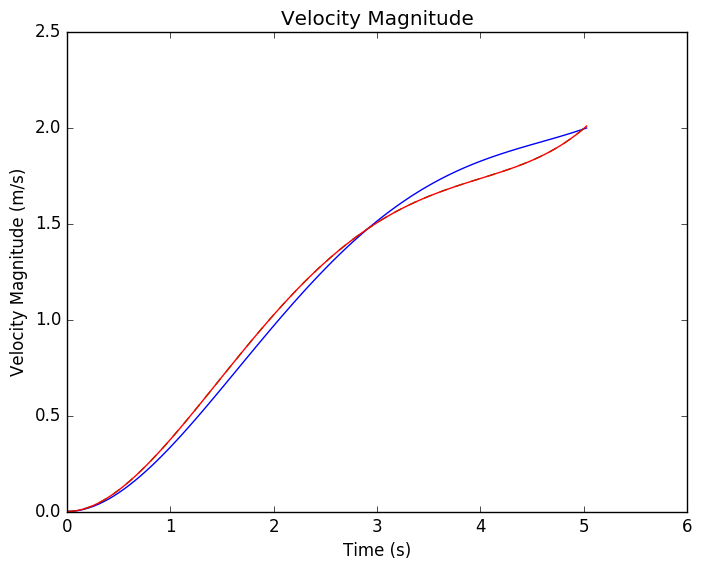

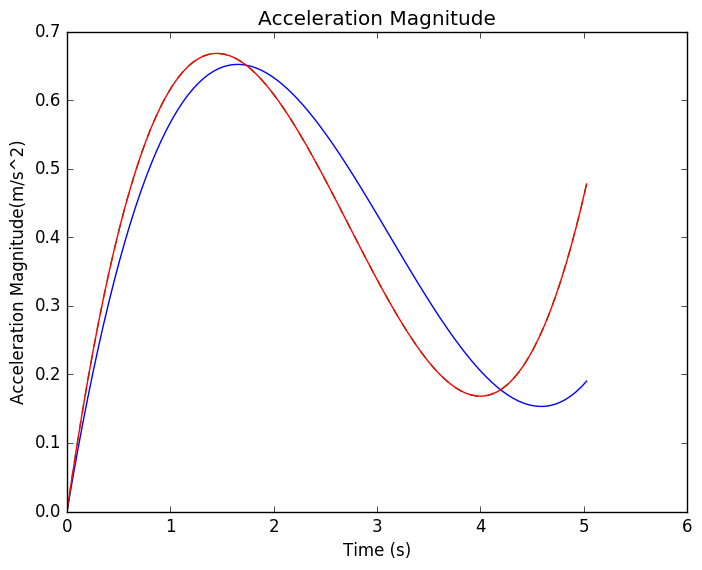

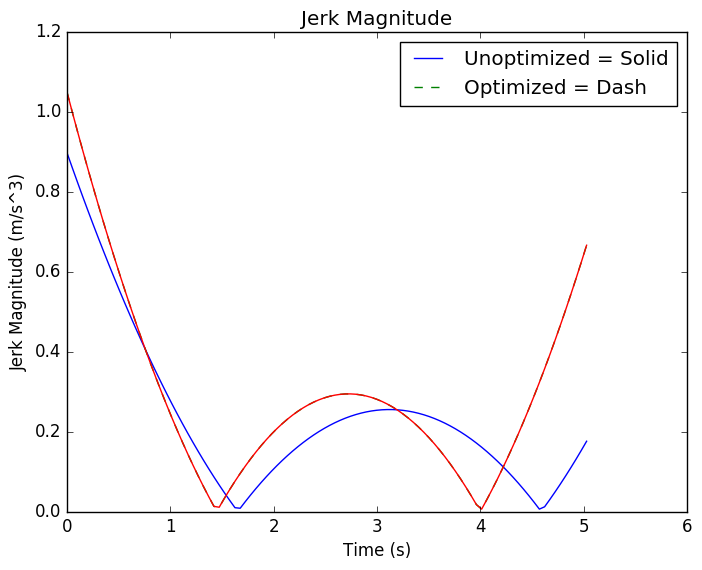

converged?: false
cost after: 96.20837263489909


PyObject <matplotlib.image.AxesImage object at 0x00000000279769B0>

In [8]:
#Psuedo Code

#Initialize solver and solution
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            true,    #    PoutOfBounds::Bool                 
                            true,    #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64    
#Create a costmap
problem.costmap = createCostMap(1,problem);

#If dijkstras Create a normalized direction vector
if(problem.DijkstraNotFMT)
    addDirectedSpeed!(problem, tuningI.max_vel);
end

#Construct the constraint vectors, orders, and timeIndex given start, end, dof and soft constraint vectors
#TODO: make void functions with pointers to avoid so much copying
problem = constructConstr(problem)

#initialize time to a reasonable time so polynomial doesn't explode, a reasonable time will be
solution.totTime = initializeTime(problem, tuningI);

#while loop until verified 
while(solvHelp.PunVerified)
    #Increment time on every loop
    solution.totTime += tuningI.timeIncrease;
    
    #Form A_inv
    solvHelp.PA_inv = constr_Ainv(  problem.PconstraintOrders,
                                    problem.PtimeIndex*solution.totTime, #Multiply by the total time for proper function
                                    problem.Pdegree);

    #Add/subtract stuff to/from q_coeff if not equal to the degree
    tuningI.q_coeff = checkQcoeffs(tuningI.q_coeff, problem.Pdegree)

    #Form Q
    solvHelp.PQ = form_Q(tuningI.q_coeff,solution.totTime);

    #Form OptimizeMat
    solvHelp.PoptimizeMatrix = form_OptimizeMat(problem,tuningI,solvHelp);

    #update the free constraints as necessary
    problem.PconstrFree = updateFreeConstr(problem,solvHelp);

    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);

    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);

    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds")
        break;
    end

    #Verify good path
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        continue; 
    end
    #If verified do not say verified  until next verify

    #Create vel, accel, and jerk matrices
    #TODO: Make better with a loop or another function?
    matVel = createDerivMat(problem.Pdegree, 1);
    matAcc = createDerivMat(problem.Pdegree, 2);
    matJerk = createDerivMat(problem.Pdegree, 3);
    
    debugPlot(solution, problem, tuningI)
    
    #Cost function
    #Create a holder for the free constr
    df = form_df(problem);
    
    #1)OPTIMIZE free constraints with limits built in; 2)COST function
    println("cost before: ", costFunc(df, solution, problem, solvHelp, tuningI))
    result = optimize(x -> costFunc(x, solution, problem, solvHelp, tuningI), df,
                                    GradientDescent());#,
                                    #OptimizationOptions(iterations = tuningI.iterations));
    
    #Save the result of the optimization
    df = Optim.minimizer(result)
    println("converged?: ", Optim.converged(result))
    println("cost after: ", costFunc(df, solution, problem, solvHelp, tuningI))
    
    #Resolve df into the respective free constraints and solve again
    problem.PconstrFree = decompose_df(df, problem);

    #solve for the polynomial coefficients
    solution.coeffs = solvePolysInitially(problem,solvHelp);

    #Check in bounds and collect the cells
    solution.cells, solvHelp.PoutOfBounds = occupancyCellChecker(solution, problem, tuningI);
    debugPlotDash(solution, problem, tuningI)
    #Break if out of bounds and display an error
    if(solvHelp.PoutOfBounds)
        println("Plan Fail: Went out of Bounds")
        break;
    end
    
    #Verify good path Number 2
    errorVals, errorTypes = simpleVerifyFeas(solution, tuningI)

    #If not verified increment time
    if(!isempty(errorVals))
        #Repeat loop over
        println("The Over Limit Values: ", errorVals)
        println("The type of Limit Broken: ", errorTypes)
        continue; 
    end
    solvHelp.PunVerified = false;
    
    #end while loop
end

debugPlot(solution, problem, tuningI)

#####DEBUGGING###############
legend(["Unoptimized = Solid", "Optimized = Dash"], loc = "Best")
###########################
if(!solvHelp.PoutOfBounds)
    figure(1)
    imshow( flipCostmap(problem.costmap),
            cmap = "gray", 
            interpolation="none",
    extent=[0,problem.grid_extent,0,problem.grid_extent])
    #PLOT optimized function?
end

#Return path

In [ ]:
#Create the optimization function for use in JuMP
#Desription: 
#Assumptions
#Inputs
# initSol - a PolySol type of the initial solution to optimize from
# theTuning - a TuningParams type for determing constraints and weights:
#   numericVelWeight::Float64          # The weight for the cost for not being at max_vel at any time
#   obstacleWeight::Float64            # The weight for the cost of going through a cell in the costmap
#   derivativeWeight::Float64          # The weight for the combined derivative cost term
#   precision::Float64                 # The tolerance to solve within
#   iterations::Int64                  # Number of times to do optimization step
#   aggressParam::Float64              # Closer to 0 means check every point on the path, infinity => check no points
#   max_vel::Float64                   # Max total velocity the path is restricted to
#   max_accel::Float64                 # Max total acceleration the path is restricted to
#   max_jerk::Float64                  # Max total jerk the path is restricted to
#   timeWeight::Float64                # Weight applied to time
#   timeRes::Int64                     # How many points for determining limits and constraints
# solvStuff - the PolyPathSolver with the following parameters to help create the objective function:
#   PA_inv::Array{Float64,2}           # The matrix that transforms constraints to coefficients A_inv*d=p
#   PQ::Array{Float64,2}               # Matrix representation of the q_coeff weights
#   PoptimizeMatrix::Array{Float64,2}  # Gives the optimal free/soft constraints given fixed constraints
#   PoutOfBounds::Bool                 # True if path ever goes outside the costmap scope
# problem - the PathProblem type that has the initial conditions and dimension flag:
#   PconstrFixed::Array{Float64,2}   # All fixed constraints
#   PconstrFree::Array{Float64,2}    # A holder for all soft and free contraints
#   isDim3::Bool                     # The flag for 3D; 2 will be added later so the dimension is only 2 or 3
#   costmap::Array{Int8,3}           # The 3D voxel occupancy grid
#   grid_extent::Float64             # The extent of the cost map in meters
#   grid_resolution::Float64         # The resolution of the cost map in meters
#   Pgrid_elementNum::Int64          # The max index of the grid of the cost map
# velMatrix - a matrix that turns a poly coeff vector into the poly coeff vector of the poly's 1st derivative
# accMatrix - a matrix that turns a poly coeff vector into the poly coeff vector of the poly's 2nd derivative
# jerkMatrix - a matrix that turns a poly coeff vector into the poly coeff vector of the poly's 3rd derivative
#Outputs
# solvSol - the optimized solution in the form the minimizing free constraints
# successful - a boolean that communicates success if true failure otherwise
function optimizeJump(initSol,theTuning,solvStuff,prob,velMatrix,accMatrix,jerkMatrix)
    ##Create model
    #Call the Model function
    m = Model()
    #Create a dim variable to know the dimension
    dim = prob.isDim3+2;
    ##Create variables
    #Create the free constraint variable starting
    #TODO: find a way to remove the length call (maybe add to one of the objects holders)
    #find the length of the free variables to determine how many there are to change and add one for time
    lenFree = size(prob.PconstrFree,2);
    #       Model,      Variable name,                Actual initial values of the constraints
    @variable(  m, free[1:dim, 1:lenFree])#, start = [prob.PconstrFree]) 
    for i in 1:dim
        for j in 1:lenFree
            setvalue(free[i,j], prob.PconstrFree[i,j]);
        end
    end
    #Create the time variable
    @variable( m, timeVar, start = initSol.totTime)
    #Create fixed variable for the fixed constraints
    @variable( m, fixed[d = 1:dim,f = 1:prob.Pdegree-lenFree,] == prob.PconstrFixed[d,f])
    
    #TODO: see if for loops work here: not sure it would since it is now a symbol 
    #TODO: think of better way of dealing with the ability to have 2 or 3 dimensions
    #Create a d matrix to hold the respective d vectors as rows and the p's
    dVecs = [fixed[1,:]' free[1,:]'];
    p =  (solvStuff.PA_inv * dVecs');
    for i = 2:(prob.isDim3+2)
        dVecs = [dVecs; fixed[i,:]' free[i,:]'];
        p = [p (solvStuff.PA_inv * dVecs[i,:])];
    end
    #Create the expression for the derivatives
    if(prob.isDim3)
        derivExpr = (p[:,1])' *          #p^T
                        solvStuff.PQ *   #Q
                        (p[:,1]) +       #p -> x coefficients cost
                     (p[:,2])' *         #p^T
                        solvStuff.PQ *   #Q
                        (p[:,2]) +       #p -> y coefficients cost
                     (p[:,3])' *         #p^T
                        solvStuff.PQ *   #Q
                        (p[:,3]);        #p -> z coefficients cost
    else
        derivExpr = (p[:,1])' *          #p^T
                        solvStuff.PQ *   #Q
                        (p[:,1]) +       #p -> x coefficients cost
                     (p[:,2])' *         #p^T
                        solvStuff.PQ *   #Q
                        (p[:,2]);        #p -> y coefficients cost
    end


    #TODO: Create maximizing velocity expression if needed: thought is that the time cost will deal with this
    #Create the time expression
    timeExpr = theTuning.timeWeight * timeVar;
    ##Create Constraints
    #Create a time vector to check the constraints and costs on
    checkTimes = [0.0];
    for i = 1:theTuning.timeRes
        checkTimes = [checkTimes i*timeVar/(theTuning.timeRes)];
    end
    for t in checkTimes
        #Create a T row vector
        T = [1.0 t^1 t^2 t^3 t^4 t^5]
        #Create the position constraints: This will make checking out of bounds obsolete most of time
        for i = 1:dim
            @NLconstraint(m, T*p[:,i] <= prob.grid_extent) #upper position bound
            @NLconstraint(m, T*p[:,i] >= 0) #lower position bounds
        end
        #initialize mapExpr
        mapExpr = 0;
        if(prob.isDim3)
            #Create the velocity constraints: This will make verification steps obsolete
            @NLconstraint(m, norm(T*velMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_vel)
            #Create the acceleration constraints: This will make verification steps obsolete
            @NLconstraint(m, norm(T*accMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_accel)
            #Create the jerk constraints: This will make verification steps obsolete
            @NLconstraint(m, norm(T*jerkMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_jerk)
            #Create the costmap expression
            mapExpr += prob.costmap[T*[p[:,1],p[:,2],p[:,3]]];
        else
            #Create the velocity constraints: This will make verification steps obsolete
            @NLconstraint(m, norm(T*velMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_vel)
            #Create the acceleration constraints: This will make verification steps obsolete
            @NLconstraint(m, norm(T*accMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_accel)
            #Create the jerk constraints: This will make verification steps obsolete
            @NLconstraint(m, norm(T*jerkMatrix*[p[:,1] p[:,2] p[:,3]]) <= theTuning.max_jerk)
            #Create the costmap expression
            mapExpr += prob.costmap[T*[p[:,1],p[:,2],1]];
        end
    end
    #Multply costmap by weight
    mapExpr *= theTuning.ObstacleWeight;
    ##Create nonlinear objective function from all the expressions
    #This requires auxillary variables in order to be used
    @variable(m, auxTime == timeExpr)
    @NLobjective(m, Min, derivExpr + mapExpr + timeExpr)
    #@objective(m, Min, derivExpr + mapExpr + timeExpr) #for testing later
    ##Solve
    #Solve for the given amount of iterations
    solve(m)
    ##Update the appropriate variables
    #Recreate a d matrix and the p's
    for i = 1:dim
        dVecs[i,:] = [prob.PconstrFixed[i,:]' free[i,:]];
        p[:,i] = (solvStuff.PA_inv * dVecs[i,:]');
    end
    return getvalue(free);
end


In [ ]:
using JuMP
m = Model()
@variable(m, x, start = 0.0)
@variable(m, y, start = 0.0)

@NLobjective(m, Min, (1-x)^2 + 100(y-x^2)^2)

solve(m)
println("x = ", getvalue(x), " y = ", getvalue(y))

# adding a (linear) constraint
@constraint(m, x + y == 10)
solve(m)
println("x = ", getvalue(x), " y = ", getvalue(y))

In [ ]:
#Control
#Construct the all the containers
tuningI = TuningParams([0;1;0;1;0],    # q_coeff::Vector{Int64}
                       [500.0;500.0],  # softConstrWeights::Vector{Float64}
                        0.1,           # numericVelWeight::Float64       
                        0.01,          # obstacleWeight::Float64    
                        0.1,           # derivativeWeight::Float64     
                        1e-8,          # precision::Float64              
                        20,            # iterations::Int64      
                        0.01,          # timeStep::Float64     
                        2.0,           # timeStart::Float64    
                        0.7,           # aggressParam:Float64        
                        0.1,           # timeIncrease::Float64            
                        2.0,           # max_vel::Float64           
                        0.65,          # max_accel::Float64        
                        10.0,          # max_jerk::Float64             
                        10,            # numberOfRandomRestarts::Int64   
                        10,            # timeWeight::Float64    
                        100);          #timeRes::Int64   
problem = PathProblem( [1.0 0.0 0.0;        # x
                        1.0 0.0 0.0;        # y
                        1.0 0.0 0.0],       # z  #start_config::Array{Float64,2}   
                       [5.0;                # x
                        6.0;                # y
                        7.0]'',             # z #end_config::Array{Float64,2}      
[true], # soft_constr::Vector{Bool}     
                        true,               # DijkstraNotFMT::Bool          
                        zeros(0,2),         # PconstrFixed::Array{Float64,2}  
    #TODO: actually create a constructor function to construct the constr* and time index vectors
                        zeros(0,2),         # PconstrFree::Array{Float64,2}       
                        [0;0;0;1;1;1],      # PtimeIndex::Vector{Int64}       
                        [0;1;2;0;1;2],      # PconstraintOrders::Vector{Int64}
                        zeros(0,2),         # PconstraintSoft::Array{Float64,2}    
                        false,              # isDim3::Bool                  
                        1,                  # dof::{Int64}                   
                        zeros(0,0,1),       # costmap::Array{Int8,3}         
                        10.0,               # grid_extent::Float64  
                        0.1,                # grid_resolution::Float64
                        0,                  # Pgrid_elementNum::Int64 
                        0)                  # Pdegree::Int64 
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            false,   #    PoutOfBounds::Bool                 
                            false,   #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64         
#Initialize solver and solution
solution = PathSol( 0.0,     # totTime::Float64 
                    [0.0]'', # coeffs::Array{Float64,2}  
                    [1],     # cells::Array{Int64,1}  
                    0.0)     # cost::Float64         
solvHelp = PolyPathSolver(  [0.0]'', #PA_inv::Array{Float64,2}           
                            [0.0]'', #    PQ::Array{Float64,2}              
                            [0.0]'', #    PoptimizeMatrix::Array{Float64,2}  
                            true,    #    PoutOfBounds::Bool                 
                            true,    #    PunVerified::Bool                
                            10,      #    counterRestart::Int64             
                            100);    #    counterVerified::Int64    
#Create a costmap
problem.costmap = createCostMap(0,problem);